In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from lora import LoRA, LoRALinear

In [26]:
### transform object to turn to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### load mnist data
mnist_dataset = datasets.MNIST(root='./data', download=True, transform=transform)

### split
train_size    = int(0.6 * len(mnist_dataset))
finetune_size = int(0.3 * len(mnist_dataset))
test_size     = len(mnist_dataset) - train_size - finetune_size

train_data, finetune_data, test_data = random_split(mnist_dataset, [train_size, finetune_size, test_size])

In [27]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 100) 
        self.fc2 = nn.Linear(100, 10)     

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

model = SimpleNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
train(model, train_loader, optimizer, criterion)

In [29]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = torch.zeros(10, 10)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy, confusion_matrix

test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
initial_loss, initial_accuracy, initial_confusion = evaluate(model, test_loader)
category_accuracy = initial_confusion.diag() / initial_confusion.sum(1)
worst_category = torch.argmin(category_accuracy).item()

for cat, acc in enumerate(category_accuracy):
    print(f'category: {cat}, accuracy: {acc}')

print(f'Worst Category: {worst_category}')

category: 0, accuracy: 0.93459552526474
category: 1, accuracy: 0.9718309640884399
category: 2, accuracy: 0.8347979187965393
category: 3, accuracy: 0.8421052694320679
category: 4, accuracy: 0.9245283007621765
category: 5, accuracy: 0.7660714387893677
category: 6, accuracy: 0.8939393758773804
category: 7, accuracy: 0.8663522005081177
category: 8, accuracy: 0.8283828496932983
category: 9, accuracy: 0.761904776096344
Worst Category: 9


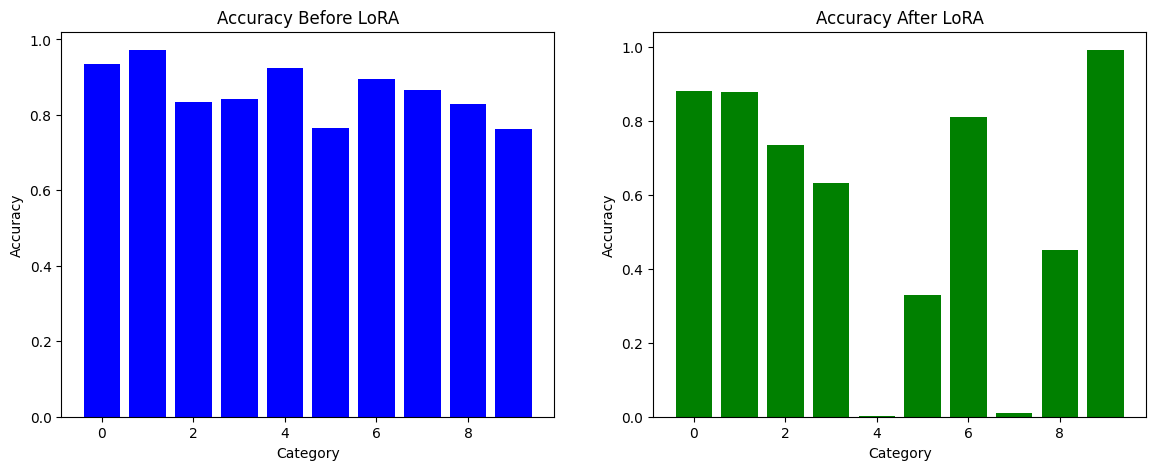

In [30]:
finetune_indices = [i for i, (img, label) in enumerate(finetune_data.dataset) if label == worst_category and i in finetune_data.indices]
finetune_subset = Subset(finetune_data.dataset, finetune_indices)
finetune_loader = DataLoader(finetune_subset, batch_size=64, shuffle=True)

# Replace and freeze layers
model.fc2 = LoRALinear(model.fc2, rank=2, alpha=1)
for param in model.fc1.parameters():
    param.requires_grad = False

# Finetune on the filtered dataset
train(model, finetune_loader, optimizer, criterion)

final_loss, final_accuracy, final_confusion = evaluate(model, test_loader)

# Calculate per-category accuracy after finetuning
final_category_accuracy = final_confusion.diag() / final_confusion.sum(1)

categories = list(range(10))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].bar(categories, category_accuracy.numpy(), color='blue')
axes[0].set_title('Accuracy Before LoRA')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Accuracy')

axes[1].bar(categories, final_category_accuracy.numpy(), color='green')
axes[1].set_title('Accuracy After LoRA')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Accuracy')

plt.show()
